# Keras LSTM Deep Learning model for Brent Crude Oil price prediction

The LSTM model performance with Mean Absolute Error (MAE) will be compared with Mean Square Error (MSE).

Data Source: U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, August 15, 2019.


Importing data is the first step in any data science project. If you want to re-do this with newer price data, download the latest CSV to your notebook's working directory and read the file.
On the Fred website, click on "Max" duration and then "Download" as CSV (data). 

In [1]:
# Find out what your notebook's working directory is and download to this directory (note: this is the MS Windows command and may differ on your system).
!echo %cd%

C:\Users\ChristianV700\Desktop


## Data loading

In [2]:
import pandas as pd

# Load csv into pandas data frame
df_data_1 = pd.read_csv('DCOILBRENTEU.csv')

# Show top of data frame
df_data_1.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [3]:
# Show tail of data frame
df_data_1.tail()

,DATE,DCOILBRENTEU
8404,2019-08-06,58.63
8405,2019-08-07,55.03
8406,2019-08-08,56.29
8407,2019-08-09,57.37
8408,2019-08-12,57.13


As we see above, the data frame contains a column with dates and one column with crude prices. Oldest up top, youngest at the bottom. There is a lag time of roughly a week until prices get added to the csv.

## Data cleaning

Unfortunately there are some missing values in the price column, which are marked with a period. The periods need to be removed.

In [4]:
booleancounter=df_data_1.apply(lambda x: True if x['DCOILBRENTEU'] == '.' else False , axis=1)
missvalue=len(booleancounter[booleancounter == True].index)
 
print('Number of days in data frame with missing value: ', missvalue)
print('Original data fram shape: ', df_data_1.shape)

# remove periods, which are missing values
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print('Cleaned up data frame shape: ',df_data_1.shape)

Number of days in data frame with missing value:  228
Original data fram shape:  (8409, 2)
Cleaned up data frame shape:  (8181, 2)


## Data Visualization

Currently, the values in the columns are stored as integer. For plotting, the price values need to be represented as floats.

In [5]:
# Pandas calls string types "object"
print("Old DCOILBRENTEU class: ",df_data_1.dtypes['DCOILBRENTEU'])

# Convert prices to numpy float array
df_data_1_plot = df_data_1.iloc[:,1:2].values.astype(float)

print("New DCOILBRENTEU class: ",df_data_1_plot.dtype)

Old DCOILBRENTEU class:  object
New DCOILBRENTEU class:  float64


In [6]:
import matplotlib.pyplot as plt

# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices (U.S. $)')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

## Importing modeling libraries

In [7]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


In [8]:
# Defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30

### Batch-size and training-set size


We split the data in 90% training and 10% test. With **stateful LSTMs** the training-set the size must be divisible without remainder by the batch-size (modulo = 0). 

In [9]:
length = len(df_data_1)
print("Total length: ",length)

training_length = length *0.9
print("Training length: ",training_length)

Total length:  8181
Training length:  7362.900000000001


Check if the training set length comes with a remainder when divided through batch size.

In [10]:
training_remainder = training_length%batch_size
training_remainder

2.9000000000005457

There is a remainder! Let's remove the remainder from the training length to get rid of the remainder.

In [11]:
training_length_new = training_length - training_remainder
print(training_length_new)
training_length_new%batch_size

7360.0


0.0

We can formalize the finding of the training set length and define a function.

In [12]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [13]:
length = get_train_length(df_data_1, batch_size, 0.1)
print(length)

7296
7360
7360


In [14]:
# Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

(7420, 1)

## Feature Scaling 0 to 1

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))

print(training_set_scaled.shape)
print("Show some scaled values: ",training_set_scaled[0:6,0])

(7420, 1)
Show some scaled values:  [0.07067112 0.0693363  0.07007786 0.07044865 0.07067112 0.07044865]


## Create x features and y labels

In [16]:
# Initialize as arrays
X_train = []
y_train = []

# Creating a data structure with n timesteps
print("length + timesteps: ",length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

# these need to be the same length
print("x_train length: ",len(X_train))
print("ny_train length: ",len(y_train))

# create X_train matrix, 30 items per array (timestep)
print("\nx_train: ",X_train[0:2])
print("x_train shape:",np.array(X_train).shape)

# create Y_train matrix, 30 items per array (timestep)
print("\ny_train: ",y_train[0:2])
print("y_train shape: ",np.array(y_train).shape)

length + timesteps:  7390
x_train length:  7360
ny_train length:  7360

x_train:  [array([0.07067112, 0.0693363 , 0.07007786, 0.07044865, 0.07067112,
       0.07044865, 0.07044865, 0.07030033, 0.07081943, 0.0710419 ,
       0.07156099, 0.07178346, 0.07081943, 0.07156099, 0.07178346,
       0.07178346, 0.0710419 , 0.07178346, 0.07267334, 0.07363737,
       0.07378569, 0.07378569, 0.07415647, 0.07267334, 0.07156099,
       0.07119021, 0.07400816, 0.07452725, 0.07400816, 0.07326659]), array([0.0693363 , 0.07007786, 0.07044865, 0.07067112, 0.07044865,
       0.07044865, 0.07030033, 0.07081943, 0.0710419 , 0.07156099,
       0.07178346, 0.07081943, 0.07156099, 0.07178346, 0.07178346,
       0.0710419 , 0.07178346, 0.07267334, 0.07363737, 0.07378569,
       0.07378569, 0.07415647, 0.07267334, 0.07156099, 0.07119021,
       0.07400816, 0.07452725, 0.07400816, 0.07326659, 0.07526882])]
x_train shape: (7360, 30)

y_train:  [array([0.07526882, 0.07586207, 0.07697442, 0.07712273, 0.07697442,
    

## Reshaping into three dimensional array

In [17]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

print(X_train.shape)
print(y_train.shape)

(7360, 30, 1)
(7360, 30, 1)


## Model design with Mean Absolute Error (MAE)

In [18]:
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

# Initialising the LSTM Model with the Keras functional API called "Model" instead of "Sequential"

# Layer 1: inputs
inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1)) # 1 = one parameter to predict

# Layer 2: LSTM 1 (input to current layer is the previous layer)
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae) # 10 = LSTM nodes

# Layer 3: LSTM 2 (input to current layer is the previous layer) # 10 = LSTM nodes
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

# Layer 4: outputs (input to current layer is the previous layer)
output_1_mae = Dense(units = 1)(lstm_2_mae)

# type of model, defining input and output
regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

# adam is fast starting off and then gets slower and more precise
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

W0815 23:42:13.546904 13336 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 23:42:13.563859 13336 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 23:42:13.567849 13336 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 23:42:14.009665 13336 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimize

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [19]:
# stateful - since we want to reset states, we need a loop over the fit function many times with one epoch instead of using the regular fit function and the full number of epochs
for i in range(epochs):
    print("Epoch: " + str(i+1)," of ",epochs)
    # run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    # resets only the states but the weights, cell and hidden are kept
    regressor_mae.reset_states()

W0815 23:42:14.221159 13336 deprecation.py:323] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 1  of  120


W0815 23:42:15.111528 13336 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0815 23:42:15.251681 13336 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/1
7360/7360 [==============================] - 13s 2ms/step - loss: 0.0526
Epoch: 2  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0592
Epoch: 3  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0626
Epoch: 4  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0595
Epoch: 5  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0580
Epoch: 6  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0570
Epoch: 7  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0561
Epoch: 8  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0555
Epoch: 9  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0542
Epoch: 10  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0531
Epoch: 

In [20]:
# stateless - between the batches the cell and hidden states are lost
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

## Save the model

In [21]:
import h5py

# save
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")

In [22]:
# load
regressor_mae = load_model(filepath="my_model_with_mae_30_ts.h5")

## Defining Test Set length

Again, define a method to define the test set length.

In [23]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [24]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2

testset_length = test_length - upper_train
print("Calculated test set length: ",testset_length)

7996
8060
8060
Calculated test set length:  640


In [25]:
print(upper_train, upper_test, len(df_data_1))

7420 8120 8181


## Creating the Test Set

In [26]:
# construct test set

# subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

# scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

# creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


# reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# size check
X_test.shape

(640, 30, 1)

In [27]:
# prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print("Before reshaping: ",predicted_bcg_values_test_mae.shape)

# reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print("After reshaping: ",predicted_bcg_values_test_mae.shape)

# inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


# creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
pred_mae = np.reshape(y_test, (y_test.shape[0], 1))
print("y test set after reshape: ",y_test.shape)

Before reshaping:  (640, 30, 1)
After reshaping:  (640, 30)
y test set after reshape:  (610,)


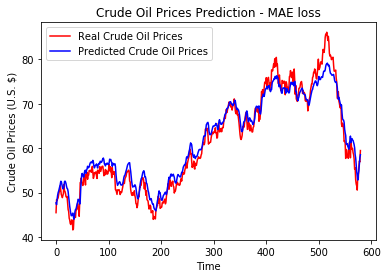

In [28]:
# Visualising the prediction on the test set
plt.plot(test_set[timesteps:len(pred_mae)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(pred_mae) - timesteps].astype(float), color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE loss')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices (U.S. $)')
plt.legend()
plt.show()

## Evaluation MAE loss prediction

In [29]:
import math
from sklearn.metrics import mean_squared_error

# RMSE on MAE loss prediction. The RMSE has the useful property of being in the same units as the response variable (US $).
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

2.19763363881638


In [32]:
mean = np.mean(np.float64(test_set[timesteps:len(pred_mae)]))
print("Mean prediction price: ",mean)

Mean prediction price:  61.03658620689655


In [33]:
rmse/mean * 100

3.600518599397141

In [34]:
from sklearn.metrics import mean_absolute_error

# MAE on MAE loss prediction
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

1.811172704762426


In [35]:
mae/mean_mae * 100

2.9673558390422903

## Design the model with MSE Loss

In [36]:
# Same LSTM model design as before

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

# mse -> mean squared error as loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_3 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_4 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_2 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [37]:
# remember, epochs = 120
for i in range(epochs):
    print("Epoch: " + str(i+1)," of ",epochs)
    regressor_mse.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse.reset_states()

Epoch: 1  of  120
Epoch 1/1
7360/7360 [==============================] - 11s 2ms/step - loss: 0.0041
Epoch: 2  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0048
Epoch: 3  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0053
Epoch: 4  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0058
Epoch: 5  of  120
Epoch 1/1
7360/7360 [==============================] - 11s 1ms/step - loss: 0.0062
Epoch: 6  of  120
Epoch 1/1
7360/7360 [==============================] - 11s 1ms/step - loss: 0.0066
Epoch: 7  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0066
Epoch: 8  of  120
Epoch 1/1
7360/7360 [==============================] - 11s 1ms/step - loss: 0.0068
Epoch: 9  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - loss: 0.0067
Epoch: 10  of  120
Epoch 1/1
7360/7360 [==============================] - 10s 1ms/step - lo

In [38]:
# save
regressor_mse.save(filepath="my_model_with_mse_30_ts.h5")

In [39]:
# load
regressor_mse = load_model(filepath="my_model_with_mse_30_ts.h5")

In [40]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

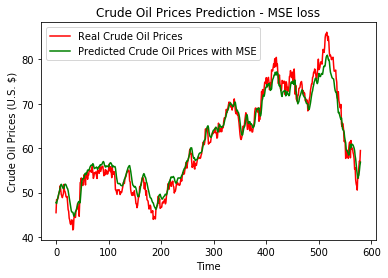

In [41]:
# Visualising the results
plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'green', label = 'Predicted Crude Oil Prices with MSE')
plt.title('Crude Oil Prices Prediction - MSE loss')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices (U.S. $)')
plt.legend()
plt.show()

## Evaluation MSE loss prediction

In [43]:
# RMSE evaluation on MSE loss prediction. The RMSE has the useful property of being in the same units as the response variable (US $).
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print(rmse)

2.0193762509331328


In [44]:
mean_mse = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print("Mean prediction price: ",mean)

Mean prediction price:  61.03658620689655


In [45]:
rmse/mean_mse * 100

3.30846853735893

In [46]:
# MSE evaluation on MSE loss prediction
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print(mae)

1.601050466340164


In [47]:
mae/mean_mse * 100

2.623099628988196